# Garbage Classification

Garbage segregation involves separating wastes according to how it's handled or processed. It's important for recycling as some materials are recyclable and others are not.

In this notebook i'll use PyTorch for classifying trash into various categories like metal, cardboard, etc.

Let us start by importing the libraries:

In [49]:
import os
import torch
import torchvision
import torch.nn.functional as F
import torchvision.models as models
import torch.nn as nn
from google.colab import drive
from torch.utils.data import random_split

## For this step you need to download the .json file from Kaggle:
1.Go to your account

2.Click account, founded in the upper right conner

3.Look for API section

4.Click Create New API Token

5.Make sure that the name is Kaggle.json

In [183]:
#Here you must select the downloaded kaggle.json file
drive.mount("/content/gdrive", force_remount=True)
! pip install -q kaggle
from google.colab import files
files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

#click 'Choose Files' botom and select kaggle.json

Mounted at /content/gdrive


Saving kaggle.json to kaggle (4).json
ref                                                             title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ahsan81/hotel-reservations-classification-dataset               Hotel Reservations Dataset                   480KB  2023-01-04 12:50:31           2689        101  1.0              
thedevastator/global-fossil-co2-emissions-by-country-2002-2022  Emissions by Country, 2002-2022              621KB  2023-01-02 20:10:36           1402         52  1.0              
die9origephit/fifa-world-cup-2022-complete-dataset              Fifa World Cup 2022: Complete Dataset          7KB  2022-12-18 22:51:11           5960        187  1.0              
rakkesharv/spotify-top-10000-streamed-songs              

In [52]:
#Install the datasets
!kaggle datasets download -d asdasdasasdas/garbage-classification 

100% 82.0M/82.0M [00:04<00:00, 24.6MB/s]
100% 82.0M/82.0M [00:04<00:00, 19.1MB/s]


In [54]:
#descomprimir los archivos zip y elimina los archivos .zip
!unzip \*.zip  && rm *.zip

Archive:  garbage-classification.zip
replace Garbage classification/Garbage classification/cardboard/cardboard1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N

Archive:  garbage-ai.zip

2 archives were successfully processed.


In [156]:
path='/content/Garbage classification/Garbage classification'

## Transformations:

Now, let's apply transformations to the dataset and import it for use.

In [157]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transf = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

data = ImageFolder(path, transform = transf)
#With the dataset number of point we know how many files are
print(data)

Dataset ImageFolder
    Number of datapoints: 2527
    Root location: /content/Garbage classification/Garbage classification
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


Let's create a helper function to see the image and its corresponding label:

In [158]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", data.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: cardboard (Class No: 0)


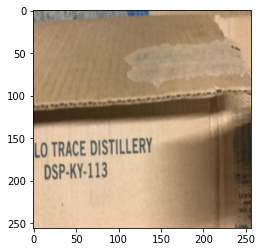

In [159]:
img, label = data[12]
show_sample(img, label)

# Loading and Splitting Data:

In [160]:
random_seed = 42
torch.manual_seed(random_seed)


We'll split the dataset into training, validation and test sets:

In [161]:
x, y, z =1593, 176, 758

#data= random_split(data, ())
train_ds, val_ds, test_ds = random_split(data, (x, y, z))
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

In [162]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

Now, we'll create training and validation dataloaders using `DataLoader`.

In [163]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


This is a helper function to visualize batches:

In [164]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

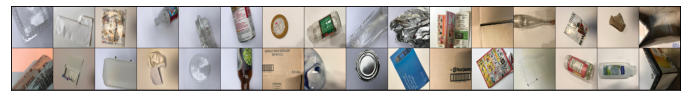

In [165]:
show_batch(train_dl)

# Model Base:

Let's create the model base:

In [166]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

We'll be using ResNet50 for classifying images:

In [167]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(data.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Porting to GPU:

GPUs tend to perform faster calculations than CPU. Let's take this advantage and use GPU for computation:

In [168]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [169]:
device = get_default_device()
device

device(type='cuda')

In [170]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

# Training the Model:

This is the function for fitting the model.

In [171]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [172]:
model = to_device(ResNet(), device)

In [173]:
evaluate(model, val_dl)

{'val_loss': 1.8006809949874878, 'val_acc': 0.1371527761220932}

Let's start training the model:

In [174]:
num_epochs = 8
opt_func = torch.optim.Adam
#choose the rigth learning rate is crucial
lr = 2.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.5919, val_loss: 1.4184, val_acc: 0.7708
Epoch 2: train_loss: 1.3302, val_loss: 1.2792, val_acc: 0.8385
Epoch 3: train_loss: 1.1995, val_loss: 1.2016, val_acc: 0.9097
Epoch 4: train_loss: 1.1249, val_loss: 1.1598, val_acc: 0.9410
Epoch 5: train_loss: 1.0891, val_loss: 1.1466, val_acc: 0.9410
Epoch 6: train_loss: 1.0749, val_loss: 1.1252, val_acc: 0.9583
Epoch 7: train_loss: 1.0691, val_loss: 1.1159, val_acc: 0.9462
Epoch 8: train_loss: 1.0616, val_loss: 1.1156, val_acc: 0.9583


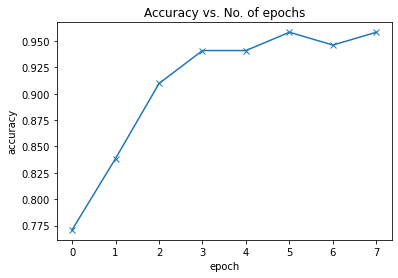

In [175]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

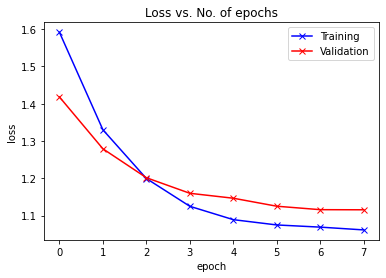

In [176]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

# Visualizing Predictions:

In [177]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return data.classes[preds[0].item()]

Let us see the model's predictions on the test dataset:

In [178]:
good=0
bad=0
for i in test_ds:
  
  img, label = i
  if data.classes[label]==predict_image(img, model):
    good=good+1
  else:
      bad=bad+1
print(good/z)


0.9300791556728232


Pick a number (0-700)200
Label: plastic , Predicted: plastic


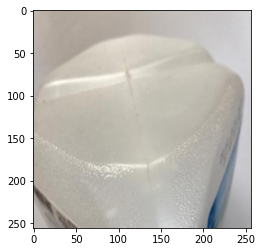

In [179]:

img, label = test_ds[int(input('Pick a number (0-700)'))]
plt.imshow(img.permute(1, 2, 0))
print('Label:', data.classes[label], ', Predicted:', predict_image(img, model))

# Conclusion:

The model is able to classify garbage with **+90% accuracy**!

Works pretty fine with test images.

You can try experimenting with more images and see the results!